In [1]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the Emotion dataset
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from scipy.sparse import hstack
import emoji
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import torch
from tqdm import tqdm
from gensim.models import word2vec
from gensim.utils import tokenize
import gensim.downloader

# Social Media Emotion Classification

The dataset classifies Tweets into anger, joy, optimism or sadness.

First we need to load the data. The data is already split into train, validation and test. The _validation_ set (also called 'development' set or 'devset') can be used to compute performance of your model when tuning hyperparameters, optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set (i.e., not to look at it at all when developing your method) to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specific examples in the test set. An alternative approach to validation is to not use a single fixed validation set, but instead use [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html). 

In [2]:
cache_dir = "./data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="train",
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset)} instances loaded")


val_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="validation",
    cache_dir=cache_dir,
)
print(f"Development/validation dataset with {len(val_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="test",
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset)} instances loaded")

# Access the input text and target labels like this...
train_texts = train_dataset['text']
train_labels = train_dataset['label']

val_texts = val_dataset['text']
val_labels = val_dataset['label']

test_texts = test_dataset['text']
test_labels = test_dataset['label']

Training dataset with 3257 instances loaded
Development/validation dataset with 374 instances loaded
Test dataset with 1421 instances loaded


In [3]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 3257
})

In [4]:
val_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 374
})

In [5]:
test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 1421
})

## Test Set

In [6]:
anger_count_test = test_labels.count(0)
joy_count_test = test_labels.count(1)
optimism_count_test = test_labels.count(2)
sadness_count_test = test_labels.count(3)

print("Anger count:", anger_count_test)
print("Joy count:", joy_count_test)
print("Optimism count:", optimism_count_test)
print("Sadness count:", sadness_count_test)
 # with (0) anger,
 # (1) joy,
 # (2) optimism 
 # or (3) sadness. 

Anger count: 558
Joy count: 358
Optimism count: 123
Sadness count: 382


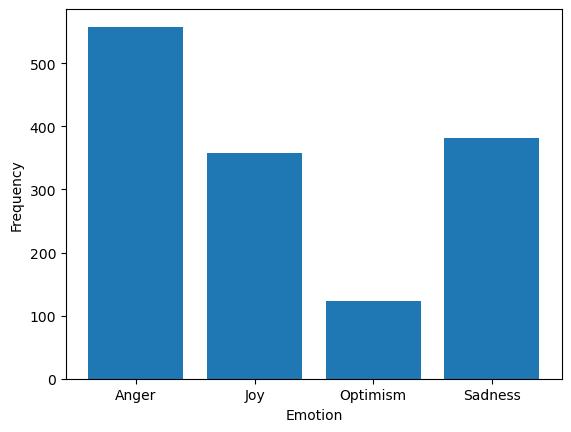

In [7]:
# plot graph to see distribution
labels = ['Anger', 'Joy', 'Optimism', 'Sadness']
counts = [anger_count_test, joy_count_test, optimism_count_test, sadness_count_test]

plt.bar(labels, counts)
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

## Train Set

In [8]:
anger_count_train = train_labels.count(0)
joy_count_train = train_labels.count(1)
optimism_count_train = train_labels.count(2)
sadness_count_train = train_labels.count(3)

print("Anger count:", anger_count_train)
print("Joy count:", joy_count_train)
print("Optimism count:", optimism_count_train)
print("Sadness count:", sadness_count_train)

Anger count: 1400
Joy count: 708
Optimism count: 294
Sadness count: 855


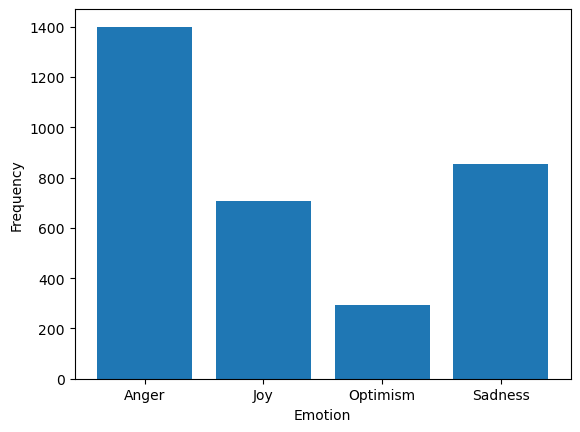

In [9]:
# plot graph to see distribution
labels = ['Anger', 'Joy', 'Optimism', 'Sadness']
counts = [anger_count_train, joy_count_train, optimism_count_train, sadness_count_train]

plt.bar(labels, counts)
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

## Val Set

In [10]:
anger_count_val = val_labels.count(0)
joy_count_val = val_labels.count(1)
optimism_count_val = val_labels.count(2)
sadness_count_val = val_labels.count(3)

print("Anger count:", anger_count_val)
print("Joy count:", joy_count_val)
print("Optimism count:", optimism_count_val)
print("Sadness count:", sadness_count_val)

Anger count: 160
Joy count: 97
Optimism count: 28
Sadness count: 89


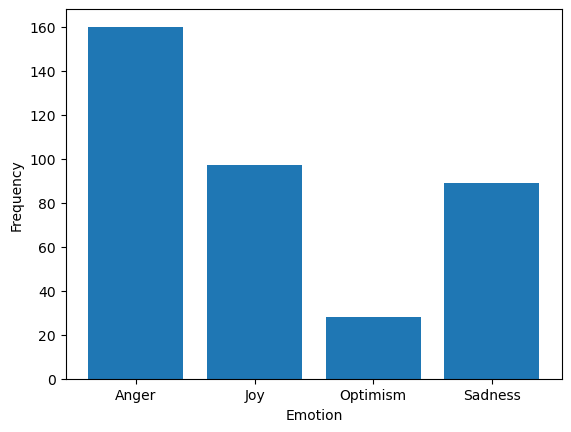

In [11]:
# plot graph to see distribution
labels = ['Anger', 'Joy', 'Optimism', 'Sadness']
counts = [anger_count_val, joy_count_val, optimism_count_val, sadness_count_val]

plt.bar(labels, counts)
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

In [12]:
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/blackrose/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/blackrose/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/blackrose/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "]+", flags=re.UNICODE)

def contains_emoji(text):
    return emoji_pattern.search(text) is not None

# check texts contain emojis
texts_with_emojis = [text for text in train_texts if contains_emoji(text)]

print(texts_with_emojis[:5])
print(len(texts_with_emojis))

['Why have I only just started watching glee this week I am now addicted 🙄 #glee #GLEEK', "@user bts' 화양연화 trilogy MV is my all time fav🙌 quite gloomy but beautiful as well✨", "Rewatching 'Raising Hope' (with hubs this time) and totally forgot how hilarious it is 😂 #HereWeGo", "On the bright side, my music theory teacher just pocket dabbed and said, 'I know what's hip.' And walked away 😂😭", "i was so embarrassed when she saw us i was like knvfkkjg she thinks we're stalkers n then she starts waving all cheerfully inviting us in 😩"]
276


# Logistic Regression

## Experiment 1 

In [14]:
# preprocessing function

# map similar emoticons to a single form
emoticon_map = {
    r":-\)|:\)|\(-:|\(:": ":)",  # happy
    r":-\(|:\(|\)-:|\)-:": ":(",  # sad
}

def group_emoticons(text):
    for emoticon_regex, emoticon_replacement in emoticon_map.items():
        text = re.sub(emoticon_regex, emoticon_replacement, text)
    return text

def normalize_repeated_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)


def preprocessing_text(text):
    
    # convert all texts to lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r'https?://\S+|\.com$', '', text)
    
    # remove HTML link
    text = re.sub(r'\<br /\>', r' ', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove email and account
    text = re.sub(r'@\w+', '', text)

         
    # # group emoticon
    # text = group_emoticons(text)
      
    # #### emoji block ####
    # # replace emojis with text
    # text = emoji.demojize(text, language='alias')

    # # remove colons and replace underscores with spaces
    # text = re.sub(r':([^:\s]*):', lambda m: m.group(1).replace('_', ' '), text)
    # #### emoji block ####


    # # remove symbols
    # text = re.sub(r'[^\w\s\!\?\$\%\#\-\&\@\+\=\_]*[\r\n]*', '', text)

  
    # # # remove repeating character like hungryyyyyyy
    # # text = normalize_repeated_letters(text)


    
    # tokenize text
    words = nltk.word_tokenize(text)


    
    # # Lemmatize words
    # lemmatizer = WordNetLemmatizer()
    # words = [lemmatizer.lemmatize(word) for word in words]


    
    # join words into string
    text = ' '.join(words)
    return text


# preprocess
train_documents = [preprocessing_text(txt) for txt in train_texts]
val_documents = [preprocessing_text(txt) for txt in val_texts]
test_documents = [preprocessing_text(txt) for txt in test_texts]



In [15]:
# new
train_documents[:5]

["“ worry is a down payment on a problem you may never have ' . joyce meyer . # motivation # leadership # worry",
 "my roommate : it 's okay that we ca n't spell because we have autocorrect . # terrible # firstworldprobs",
 "no but that 's so cute . atsu was probably shy about photos before but cherry helped her out uwu",
 "rooneys fucking untouchable is n't he ? been fucking dreadful again , depay has looked decent ( ish ) tonight",
 "it 's pretty depressing when u hit pan on ur favourite highlighter"]

In [16]:
val_documents[:1]

['oh , hidden revenge and anger ... i rememberthe time , she rebutted you .']

In [17]:
vectorizer = CountVectorizer()

vectorizer.fit(train_documents)
X_train = vectorizer.fit_transform(train_documents)
X_val = vectorizer.transform(val_documents)
X_test = vectorizer.transform(test_documents)

In [18]:
# train model on train set
classifier = LogisticRegression(max_iter=1000, random_state=10)
classifier.fit(X_train, train_labels)

# predict on train and validation set
y_val_pred = classifier.predict(X_val)
y_train_pred = classifier.predict(X_train)
acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy of validation = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) of validation = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) of validation = {rec}')


f1 = f1_score(train_labels, y_train_pred, average='macro')
print(f'F1 score (macro average) of train = {f1}')


f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) of validation = {f1}')

print(classification_report(val_labels, y_val_pred))

Accuracy of validation = 0.6417112299465241
Precision (macro average) of validation = 0.6083738729855896
Recall (macro average) of validation = 0.5650022598087074
F1 score (macro average) of train = 0.9871118219741745
F1 score (macro average) of validation = 0.5799351319475159
              precision    recall  f1-score   support

           0       0.64      0.79      0.71       160
           1       0.71      0.54      0.61        97
           2       0.45      0.36      0.40        28
           3       0.62      0.57      0.60        89

    accuracy                           0.64       374
   macro avg       0.61      0.57      0.58       374
weighted avg       0.64      0.64      0.63       374



## Experiment 2

In [19]:
# preprocessing function

emoticon_map = {
    r":-\)|:\)|\(-:|\(:": ":)",  
    r":-\(|:\(|\)-:|\)-:": ":(",  
}

def group_emoticons(text):
    for emoticon_regex, emoticon_replacement in emoticon_map.items():
        text = re.sub(emoticon_regex, emoticon_replacement, text)
    return text

def normalize_repeated_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)


def preprocessing_text(text):
    
    # convert all texts to lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r'https?://\S+|\.com$', '', text)
    
    # remove HTML link
    text = re.sub(r'\<br /\>', r' ', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove email and account
    text = re.sub(r'@\w+', '', text)

         
    
    #### emoji block ####
    # replace emojis with text
    text = emoji.demojize(text, language='alias')

    # remove colons and replace underscores with spaces
    text = re.sub(r':([^:\s]*):', lambda m: m.group(1).replace('_', ' '), text)
    #### emoji block ####

    # # group emoticon
    # text = group_emoticons(text)

    # # remove symbols
    # text = re.sub(r'[^\w\s\!\?\$\%\#\-\&\@\+\=\_]*[\r\n]*', '', text)

  
    # # # remove repeating character like hungryyyyyyy
    # # text = normalize_repeated_letters(text)


    
    # tokenize text
    words = nltk.word_tokenize(text)


    
    # # Lemmatize words
    # lemmatizer = WordNetLemmatizer()
    # words = [lemmatizer.lemmatize(word) for word in words]


    
    # join words into string
    text = ' '.join(words)
    return text


# preprocess
train_documents = [preprocessing_text(txt) for txt in train_texts]
val_documents = [preprocessing_text(txt) for txt in val_texts]
test_documents = [preprocessing_text(txt) for txt in test_texts]



In [20]:
vectorizer = CountVectorizer()

vectorizer.fit(train_documents)
X_train = vectorizer.fit_transform(train_documents)
X_val = vectorizer.transform(val_documents)
X_test = vectorizer.transform(test_documents)

In [21]:
# train model on train set
classifier = LogisticRegression(max_iter=1000, random_state=10)
classifier.fit(X_train, train_labels)

# predict on train and validation set
y_val_pred = classifier.predict(X_val)
y_train_pred = classifier.predict(X_train)

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy of validation = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) of validation = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) of validation = {rec}')

f1 = f1_score(train_labels, y_train_pred, average='macro')
print(f'F1 score (macro average) of train = {f1}')

f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) of validation = {f1}')

print(classification_report(val_labels, y_val_pred))

Accuracy of validation = 0.6737967914438503
Precision (macro average) of validation = 0.6430566052239619
Recall (macro average) of validation = 0.5993804142327612
F1 score (macro average) of train = 0.9895155790938127
F1 score (macro average) of validation = 0.614585862730663
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       160
           1       0.73      0.56      0.63        97
           2       0.52      0.39      0.45        28
           3       0.63      0.63      0.63        89

    accuracy                           0.67       374
   macro avg       0.64      0.60      0.61       374
weighted avg       0.67      0.67      0.67       374



## Experiment 3

In [22]:
# preprocessing function

emoticon_map = {
    r":-\)|:\)|\(-:|\(:": ":)",
    r":-\(|:\(|\)-:|\)-:": ":(",
}

def group_emoticons(text):
    for emoticon_regex, emoticon_replacement in emoticon_map.items():
        text = re.sub(emoticon_regex, emoticon_replacement, text)
    return text

def normalize_repeated_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)


def preprocessing_text(text):
    
    # convert all texts to lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r'https?://\S+|\.com$', '', text)
    
    # remove HTML link
    text = re.sub(r'\<br /\>', r' ', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove email and account
    text = re.sub(r'@\w+', '', text)

         
    
    #### emoji block ####
    # replace emojis with text
    text = emoji.demojize(text, language='alias')

    # remove colons and replace underscores with spaces
    text = re.sub(r':([^:\s]*):', lambda m: m.group(1).replace('_', ' '), text)
    #### emoji block ####

    # group emoticon
    text = group_emoticons(text)

    # # remove symbols
    # text = re.sub(r'[^\w\s\!\?\$\%\#\-\&\@\+\=\_]*[\r\n]*', '', text)

  
    # # # remove repeating character like hungryyyyyyy
    # # text = normalize_repeated_letters(text)


    
    # tokenize text
    words = nltk.word_tokenize(text)


    
    # # Lemmatize words
    # lemmatizer = WordNetLemmatizer()
    # words = [lemmatizer.lemmatize(word) for word in words]


    
    # join words into string
    text = ' '.join(words)
    return text


# preprocess
train_documents = [preprocessing_text(txt) for txt in train_texts]
val_documents = [preprocessing_text(txt) for txt in val_texts]
test_documents = [preprocessing_text(txt) for txt in test_texts]



In [23]:
vectorizer = CountVectorizer()

vectorizer.fit(train_documents)
X_train = vectorizer.fit_transform(train_documents)
X_val = vectorizer.transform(val_documents)
X_test = vectorizer.transform(test_documents)


# train model on train set
classifier = LogisticRegression(max_iter=1000, random_state=10)
classifier.fit(X_train, train_labels)

# predict on train and validation set
y_val_pred = classifier.predict(X_val)
y_train_pred = classifier.predict(X_train)

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy of validation = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) of validation = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) of validation = {rec}')



f1 = f1_score(train_labels, y_train_pred, average='macro')
print(f'F1 score (macro average) of train = {f1}')



f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) of validation = {f1}')

print(classification_report(val_labels, y_val_pred))

Accuracy of validation = 0.6737967914438503
Precision (macro average) of validation = 0.6430566052239619
Recall (macro average) of validation = 0.5993804142327612
F1 score (macro average) of train = 0.9895155790938127
F1 score (macro average) of validation = 0.614585862730663
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       160
           1       0.73      0.56      0.63        97
           2       0.52      0.39      0.45        28
           3       0.63      0.63      0.63        89

    accuracy                           0.67       374
   macro avg       0.64      0.60      0.61       374
weighted avg       0.67      0.67      0.67       374



## Experiment 4

In [24]:
# preprocessing function

emoticon_map = {
    r":-\)|:\)|\(-:|\(:": ":)", 
    r":-\(|:\(|\)-:|\)-:": ":(", 
}

def group_emoticons(text):
    for emoticon_regex, emoticon_replacement in emoticon_map.items():
        text = re.sub(emoticon_regex, emoticon_replacement, text)
    return text

def normalize_repeated_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)


def preprocessing_text(text):
    
    # convert all texts to lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r'https?://\S+|\.com$', '', text)
    
    # remove HTML link
    text = re.sub(r'\<br /\>', r' ', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove email and account
    text = re.sub(r'@\w+', '', text)

         
    
    #### emoji block ####
    # replace emojis with text
    text = emoji.demojize(text, language='alias')

    # remove colons and replace underscores with spaces
    text = re.sub(r':([^:\s]*):', lambda m: m.group(1).replace('_', ' '), text)
    #### emoji block ####

    # group emoticon
    text = group_emoticons(text)

    # remove symbols
    text = re.sub(r'[^\w\s\!\?\$\%\#\-\&\@\+\=\_]*[\r\n]*', '', text)

  
    # # # remove repeating character like hungryyyyyyy
    # # text = normalize_repeated_letters(text)


    
    # tokenize text
    words = nltk.word_tokenize(text)


    
    # # Lemmatize words
    # lemmatizer = WordNetLemmatizer()
    # words = [lemmatizer.lemmatize(word) for word in words]


    
    # join words into string
    text = ' '.join(words)
    return text


# preprocess
train_documents = [preprocessing_text(txt) for txt in train_texts]
val_documents = [preprocessing_text(txt) for txt in val_texts]
test_documents = [preprocessing_text(txt) for txt in test_texts]


In [25]:
vectorizer = CountVectorizer()

vectorizer.fit(train_documents)
X_train = vectorizer.fit_transform(train_documents)
X_val = vectorizer.transform(val_documents)
X_test = vectorizer.transform(test_documents)


# train model on train set
classifier = LogisticRegression(max_iter=1000, random_state=10)
classifier.fit(X_train, train_labels)

# predict on train and validation set
y_val_pred = classifier.predict(X_val)
y_train_pred = classifier.predict(X_train)

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy of validation = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) of validation = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) of validation = {rec}')



f1 = f1_score(train_labels, y_train_pred, average='macro')
print(f'F1 score (macro average) of train = {f1}')



f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) of validation = {f1}')

print(classification_report(val_labels, y_val_pred))


Accuracy of validation = 0.6818181818181818
Precision (macro average) of validation = 0.655175236589902
Recall (macro average) of validation = 0.5974849932154027
F1 score (macro average) of train = 0.9894432415799941
F1 score (macro average) of validation = 0.6168099081158509
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       160
           1       0.77      0.58      0.66        97
           2       0.53      0.36      0.43        28
           3       0.65      0.62      0.63        89

    accuracy                           0.68       374
   macro avg       0.66      0.60      0.62       374
weighted avg       0.68      0.68      0.67       374



## Experiment 5 (EXP2 in report)

In [26]:
# preprocessing function

emoticon_map = {
    r":-\)|:\)|\(-:|\(:": ":)",
    r":-\(|:\(|\)-:|\)-:": ":(",
}

def group_emoticons(text):
    for emoticon_regex, emoticon_replacement in emoticon_map.items():
        text = re.sub(emoticon_regex, emoticon_replacement, text)
    return text

def normalize_repeated_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)


def preprocessing_text(text):
    
    # convert all texts to lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r'https?://\S+|\.com$', '', text)
    
    # remove HTML link
    text = re.sub(r'\<br /\>', r' ', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove email and account
    text = re.sub(r'@\w+', '', text)

         
    
    #### emoji block ####
    # replace emojis with text
    text = emoji.demojize(text, language='alias')

    # remove colons and replace underscores with spaces
    text = re.sub(r':([^:\s]*):', lambda m: m.group(1).replace('_', ' '), text)
    #### emoji block ####

    # group emoticon
    text = group_emoticons(text)

    # remove symbols
    text = re.sub(r'[^\w\s\!\?\$\%\#\-\&\@\+\=\_]*[\r\n]*', '', text)

  
    # remove repeating character like hungryyyyyyy
    text = normalize_repeated_letters(text)


    
    # tokenize text
    words = nltk.word_tokenize(text)


    
    # # Lemmatize words
    # lemmatizer = WordNetLemmatizer()
    # words = [lemmatizer.lemmatize(word) for word in words]


    
    # join words into string
    text = ' '.join(words)
    return text


# preprocess
train_documents = [preprocessing_text(txt) for txt in train_texts]
val_documents = [preprocessing_text(txt) for txt in val_texts]
test_documents = [preprocessing_text(txt) for txt in test_texts]


In [27]:
vectorizer = CountVectorizer()

vectorizer.fit(train_documents)
X_train = vectorizer.fit_transform(train_documents)
X_val = vectorizer.transform(val_documents)
X_test = vectorizer.transform(test_documents)


# train model on train set
classifier = LogisticRegression(max_iter=1000, random_state=10)
classifier.fit(X_train, train_labels)

# predict on train and validation set
y_val_pred = classifier.predict(X_val)
y_train_pred = classifier.predict(X_train)

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy of validation = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) of validation = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) of validation = {rec}')

f1 = f1_score(train_labels, y_train_pred, average='macro')
print(f'F1 score (macro average) of train = {f1}')


f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) of validation  = {f1}')

print(classification_report(val_labels, y_val_pred))

Accuracy of validation = 0.6818181818181818
Precision (macro average) of validation = 0.6545093741694062
Recall (macro average) of validation = 0.5974849932154027
F1 score (macro average) of train = 0.9894432415799941
F1 score (macro average) of validation  = 0.6167602763821494
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       160
           1       0.76      0.58      0.65        97
           2       0.53      0.36      0.43        28
           3       0.65      0.62      0.64        89

    accuracy                           0.68       374
   macro avg       0.65      0.60      0.62       374
weighted avg       0.68      0.68      0.67       374



## Experiment 6 (EXP4 in report)

In [28]:
# preprocessing function

emoticon_map = {
    r":-\)|:\)|\(-:|\(:": ":)",
    r":-\(|:\(|\)-:|\)-:": ":(",
}

def group_emoticons(text):
    for emoticon_regex, emoticon_replacement in emoticon_map.items():
        text = re.sub(emoticon_regex, emoticon_replacement, text)
    return text

def normalize_repeated_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)


def preprocessing_text(text):
    
    # convert all texts to lowercase
    text = text.lower()
    
    # remove URLs (start with http or end with .com)
    text = re.sub(r'https?://\S+|\.com$', '', text)
    
    # remove HTML link
    text = re.sub(r'\<br /\>', r' ', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove email and account
    text = re.sub(r'@\w+', '', text)

         
    
    #### emoji block ####
    # replace emojis with text
    text = emoji.demojize(text, language='alias')

    # remove colons and replace underscores with spaces
    text = re.sub(r':([^:\s]*):', lambda m: m.group(1).replace('_', ' '), text)
    #### emoji block ####

    # group emoticon
    text = group_emoticons(text)

    # remove symbols
    text = re.sub(r'[^\w\s\!\?\$\%\#\-\&\@\+\=\_]*[\r\n]*', '', text)

  
    # remove repeating character like hungryyyyyyy
    text = normalize_repeated_letters(text)


    
    # tokenize text
    words = nltk.word_tokenize(text)


    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]


    
    # join words into string
    text = ' '.join(words)
    return text


# preprocess
train_documents = [preprocessing_text(txt) for txt in train_texts]
val_documents = [preprocessing_text(txt) for txt in val_texts]
test_documents = [preprocessing_text(txt) for txt in test_texts]



In [29]:
vectorizer = CountVectorizer()

vectorizer.fit(train_documents)
X_train = vectorizer.fit_transform(train_documents)
X_val = vectorizer.transform(val_documents)
X_test = vectorizer.transform(test_documents)


# train model on train set
classifier = LogisticRegression(max_iter=1000, random_state=10)
classifier.fit(X_train, train_labels)

# predict on train and validation set
y_val_pred = classifier.predict(X_val)
y_train_pred = classifier.predict(X_train)

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy of validation = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) of validation = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) of validation = {rec}')

f1 = f1_score(train_labels, y_train_pred, average='macro')
print(f'F1 score (macro average) of train = {f1}')


f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) of validation = {f1}')

print(classification_report(val_labels, y_val_pred))


Accuracy of validation = 0.6871657754010695
Precision (macro average) of validation = 0.6486891045077825
Recall (macro average) of validation = 0.6006099932154026
F1 score (macro average) of train = 0.988164857845526
F1 score (macro average) of validation = 0.6170937368328054
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       160
           1       0.75      0.58      0.65        97
           2       0.50      0.36      0.42        28
           3       0.65      0.62      0.63        89

    accuracy                           0.69       374
   macro avg       0.65      0.60      0.62       374
weighted avg       0.68      0.69      0.68       374



## Experiment 7 (EXP3 in report)

In [30]:
# preprocessing function

emoticon_map = {
    r":-\)|:\)|\(-:|\(:": ":)",
    r":-\(|:\(|\)-:|\)-:": ":(",
}

def group_emoticons(text):
    for emoticon_regex, emoticon_replacement in emoticon_map.items():
        text = re.sub(emoticon_regex, emoticon_replacement, text)
    return text

def normalize_repeated_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)


def preprocessing_text(text):
    
    # convert all texts to lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r'https?://\S+|\.com$', '', text)
    
    # remove HTML link
    text = re.sub(r'\<br /\>', r' ', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove email and account
    text = re.sub(r'@\w+', '', text)

         
    
    #### emoji block ####
    # replace emojis with text
    text = emoji.demojize(text, language='alias')

    # remove colons and replace underscores with spaces
    text = re.sub(r':([^:\s]*):', lambda m: m.group(1).replace('_', ' '), text)
    #### emoji block ####

    # group emoticon
    text = group_emoticons(text)

    # remove symbols
    text = re.sub(r'[^\w\s\!\?\$\%\#\-\&\@\+\=\_]*[\r\n]*', '', text)

  
    # remove repeating character like hungryyyyyyy
    text = normalize_repeated_letters(text)
    
    
    # tokenize text
    words = nltk.word_tokenize(text)


    
    # Lemmatize words
    # lemmatizer = WordNetLemmatizer()
    # words = [lemmatizer.lemmatize(word) for word in words]

    # Stemming words
    stemmer = nltk.PorterStemmer() 
    words = [stemmer.stem(word) for word in words]

    # join words into string
    text = ' '.join(words)
    return text


# preprocess
train_documents = [preprocessing_text(txt) for txt in train_texts]
val_documents = [preprocessing_text(txt) for txt in val_texts]
test_documents = [preprocessing_text(txt) for txt in test_texts]


In [31]:
vectorizer = CountVectorizer()

vectorizer.fit(train_documents)
X_train = vectorizer.fit_transform(train_documents)
X_val = vectorizer.transform(val_documents)
X_test = vectorizer.transform(test_documents)


# train model on train set
classifier = LogisticRegression(max_iter=1000, random_state=10)
classifier.fit(X_train, train_labels)

# predict on train and validation set
y_val_pred = classifier.predict(X_val)
y_train_pred = classifier.predict(X_train)

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy of validation = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) of validation = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) of validation = {rec}')


f1 = f1_score(train_labels, y_train_pred, average='macro')
print(f'F1 score (macro average) of train = {f1}')



f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) of validation = {f1}')

print(classification_report(val_labels, y_val_pred))


Accuracy of validation = 0.6818181818181818
Precision (macro average) of validation = 0.6222993020437956
Recall (macro average) of validation = 0.5916852226092568
F1 score (macro average) of train = 0.9857447526995413
F1 score (macro average) of validation = 0.6029609843466261
              precision    recall  f1-score   support

           0       0.71      0.83      0.76       160
           1       0.76      0.62      0.68        97
           2       0.39      0.32      0.35        28
           3       0.63      0.60      0.61        89

    accuracy                           0.68       374
   macro avg       0.62      0.59      0.60       374
weighted avg       0.68      0.68      0.68       374



## Experiment 8 ADD NOT_


In [32]:
# preprocessing function

emoticon_map = {
    r":-\)|:\)|\(-:|\(:": ":)",
    r":-\(|:\(|\)-:|\)-:": ":(",
}

def group_emoticons(text):
    for emoticon_regex, emoticon_replacement in emoticon_map.items():
        text = re.sub(emoticon_regex, emoticon_replacement, text)
    return text

def normalize_repeated_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)


def negate_seq(text):
    words = nltk.word_tokenize(text)
    new_words = []
    negation = False

    for i, word in enumerate(words):
        if word.lower() in ["not", "no", "never", "nobody", "nothing", "neither", "nowhere", "cannot"] and i + 1 < len(words):
            new_words.append("NOT_" + words[i + 1]) 
            negation = True
            continue 
        if negation:
            negation = False
            continue
        new_words.append(word)

    return ' '.join(new_words)


    
def preprocessing_text(text):
    
    # convert all texts to lowercase
    text = text.lower()


    # remove URLs
    text = re.sub(r'https?://\S+|\.com$', '', text)
    
    # remove HTML link
    text = re.sub(r'\<br /\>', r' ', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove email and account
    text = re.sub(r'@\w+', '', text)

         
    
    #### emoji block ####
    # replace emojis with text
    text = emoji.demojize(text, language='alias')

    # remove colons and replace underscores with spaces
    text = re.sub(r':([^:\s]*):', lambda m: m.group(1).replace('_', ' '), text)
    #### emoji block ####

    # group emoticon
    text = group_emoticons(text)

    # remove symbols
    text = re.sub(r'[^\w\s\!\?\$\%\#\-\&\@\+\=\_]*[\r\n]*', '', text)

      
    # remove repeating character like hungryyyyyyy
    text = normalize_repeated_letters(text)

    # Negate sequence
    text = negate_seq(text)

    # tokenize text
    words = nltk.word_tokenize(text)


    
    # Lemmatize words
    # lemmatizer = WordNetLemmatizer()
    # words = [lemmatizer.lemmatize(word) for word in words]

    # # Stemming words
    stemmer = nltk.PorterStemmer() 
    words = [stemmer.stem(word) for word in words]

    # join words into string
    text = ' '.join(words)
    return text


# # preprocess
train_documents = [preprocessing_text(txt) for txt in train_texts]
val_documents = [preprocessing_text(txt) for txt in val_texts]
test_documents = [preprocessing_text(txt) for txt in test_texts]



In [33]:
vectorizer = CountVectorizer()

vectorizer.fit(train_documents)
X_train = vectorizer.fit_transform(train_documents)
X_val = vectorizer.transform(val_documents)
X_test = vectorizer.transform(test_documents)


# train model on train set
classifier = LogisticRegression(max_iter=1000, random_state=10)
classifier.fit(X_train, train_labels)

# predict on train and validation set
y_val_pred = classifier.predict(X_val)
y_train_pred = classifier.predict(X_train)

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy of validation = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) of validation = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) of validation = {rec}')


f1 = f1_score(train_labels, y_train_pred, average='macro')
print(f'F1 score (macro average) of train = {f1}')



f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) of validation = {f1}')

print(classification_report(val_labels, y_val_pred))


Accuracy of validation = 0.6764705882352942
Precision (macro average) of validation = 0.6227349979828499
Recall (macro average) of validation = 0.5882404105508762
F1 score (macro average) of train = 0.9856830299310171
F1 score (macro average) of validation = 0.6002613748169077
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       160
           1       0.73      0.58      0.64        97
           2       0.43      0.32      0.37        28
           3       0.63      0.63      0.63        89

    accuracy                           0.68       374
   macro avg       0.62      0.59      0.60       374
weighted avg       0.67      0.68      0.67       374



## Experiment 9 ADD NOT_ but with Lemma (EXP5 in report)

In [34]:
# preprocessing function

emoticon_map = {
    r":-\)|:\)|\(-:|\(:": ":)",
    r":-\(|:\(|\)-:|\)-:": ":(",
}

def group_emoticons(text):
    for emoticon_regex, emoticon_replacement in emoticon_map.items():
        text = re.sub(emoticon_regex, emoticon_replacement, text)
    return text

def normalize_repeated_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)


def negate_seq(text):
    words = nltk.word_tokenize(text)
    new_words = []
    negation = False

    for i, word in enumerate(words):
        if word.lower() in ["not", "no", "never", "nobody", "nothing", "neither", "nowhere", "cannot"] and i + 1 < len(words):
            new_words.append("NOT_" + words[i + 1]) 
            negation = True
            continue 
        if negation:
            negation = False
            continue
        new_words.append(word)

    return ' '.join(new_words)


    
def preprocessing_text(text):
    
    # convert all texts to lowercase
    text = text.lower()

    # remove URLs
    text = re.sub(r'https?://\S+|\.com$', '', text)
    
    # remove HTML link
    text = re.sub(r'\<br /\>', r' ', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove email and account
    text = re.sub(r'@\w+', '', text)

    
    #### emoji block ####
    # replace emojis with text
    text = emoji.demojize(text, language='alias')

    # remove colons and replace underscores with spaces
    text = re.sub(r':([^:\s]*):', lambda m: m.group(1).replace('_', ' '), text)
    #### emoji block ####

    # group emoticon
    text = group_emoticons(text)

    # remove symbols
    text = re.sub(r'[^\w\s\!\?\$\%\#\-\&\@\+\=\_]*[\r\n]*', '', text)

      
    # remove repeating character like hungryyyyyyy
    text = normalize_repeated_letters(text)

    # negate sequence
    text = negate_seq(text)

    # tokenize text
    words = nltk.word_tokenize(text)


    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # # Stemming words
    # stemmer = nltk.PorterStemmer() 
    # words = [stemmer.stem(word) for word in words]

    # join words into string
    text = ' '.join(words)
    return text


# # preprocess
train_documents = [preprocessing_text(txt) for txt in train_texts]
val_documents = [preprocessing_text(txt) for txt in val_texts]
test_documents = [preprocessing_text(txt) for txt in test_texts]



In [35]:
vectorizer = CountVectorizer()

vectorizer.fit(train_documents)
X_train = vectorizer.fit_transform(train_documents)
X_val = vectorizer.transform(val_documents)
X_test = vectorizer.transform(test_documents)


# train model on train set
classifier = LogisticRegression(max_iter=1000, random_state=10)
classifier.fit(X_train, train_labels)

# predict on train and validation set
y_val_pred = classifier.predict(X_val)
y_train_pred = classifier.predict(X_train)

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy of validation = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) of validation = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) of validation = {rec}')


f1 = f1_score(train_labels, y_train_pred, average='macro')
print(f'F1 score (macro average) of train = {f1}')



f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) of validation = {f1}')

print(classification_report(val_labels, y_val_pred))


Accuracy of validation = 0.679144385026738
Precision (macro average) of validation = 0.6491217931008507
Recall (macro average) of validation = 0.5938928540401449
F1 score (macro average) of train = 0.9875227448655992
F1 score (macro average) of validation = 0.6116758591014884
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       160
           1       0.73      0.56      0.63        97
           2       0.56      0.36      0.43        28
           3       0.60      0.62      0.61        89

    accuracy                           0.68       374
   macro avg       0.65      0.59      0.61       374
weighted avg       0.68      0.68      0.67       374



## Experiment 10 ADD NOT_ but with Lemma ADD stop (EXP6 in report)

In [36]:
# preprocessing function

emoticon_map = {
    r":-\)|:\)|\(-:|\(:": ":)",
    r":-\(|:\(|\)-:|\)-:": ":(",
}

def group_emoticons(text):
    for emoticon_regex, emoticon_replacement in emoticon_map.items():
        text = re.sub(emoticon_regex, emoticon_replacement, text)
    return text

def normalize_repeated_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)


def negate_seq(text):
    words = nltk.word_tokenize(text)
    new_words = []
    negation = False

    for i, word in enumerate(words):
        if word.lower() in ["not", "no", "never", "nobody", "nothing", "neither", "nowhere", "cannot"] and i + 1 < len(words):
            new_words.append("NOT_" + words[i + 1])
            negation = True
            continue
        if negation:
            negation = False 
            continue
        new_words.append(word)

    return ' '.join(new_words)


    
def preprocessing_text(text):
    
    # convert all texts to lowercase
    text = text.lower()


    # remove URLs
    text = re.sub(r'https?://\S+|\.com$', '', text)
    
    # remove HTML link
    text = re.sub(r'\<br /\>', r' ', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove email and account
    text = re.sub(r'@\w+', '', text)

         
    
    #### emoji block ####
    # replace emojis with text
    text = emoji.demojize(text, language='alias')

    # remove colons and replace underscores with spaces
    text = re.sub(r':([^:\s]*):', lambda m: m.group(1).replace('_', ' '), text)
    #### emoji block ####

    # group emoticon
    text = group_emoticons(text)

    # remove symbols
    text = re.sub(r'[^\w\s\!\?\$\%\#\-\&\@\+\=\_]*[\r\n]*', '', text)

      
    # remove repeating character like hungryyyyyyy
    text = normalize_repeated_letters(text)

    # negate sequence
    text = negate_seq(text)

    # tokenize text
    words = nltk.word_tokenize(text)

    # remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # # Stemming words
    # stemmer = nltk.PorterStemmer() 
    # words = [stemmer.stem(word) for word in words]

    # join words into string
    text = ' '.join(words)
    return text


# # preprocess
train_documents = [preprocessing_text(txt) for txt in train_texts]
val_documents = [preprocessing_text(txt) for txt in val_texts]
test_documents = [preprocessing_text(txt) for txt in test_texts]



In [37]:
vectorizer = CountVectorizer()

vectorizer.fit(train_documents)
X_train = vectorizer.fit_transform(train_documents)
X_val = vectorizer.transform(val_documents)
X_test = vectorizer.transform(test_documents)


# train model on train set
classifier = LogisticRegression(max_iter=1000, random_state=10)
classifier.fit(X_train, train_labels)

# predict on train and validation set
y_val_pred = classifier.predict(X_val)
y_train_pred = classifier.predict(X_train)

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy of validation = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) of validation = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) of validation = {rec}')


f1 = f1_score(train_labels, y_train_pred, average='macro')
print(f'F1 score (macro average) of train = {f1}')



f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) of validation = {f1}')

print(classification_report(val_labels, y_val_pred))


Accuracy of validation = 0.6737967914438503
Precision (macro average) of validation = 0.6124698258485284
Recall (macro average) of validation = 0.5712507601644851
F1 score (macro average) of train = 0.9876566570998517
F1 score (macro average) of validation = 0.5843175830037117
              precision    recall  f1-score   support

           0       0.71      0.83      0.76       160
           1       0.73      0.61      0.66        97
           2       0.41      0.25      0.31        28
           3       0.60      0.60      0.60        89

    accuracy                           0.67       374
   macro avg       0.61      0.57      0.58       374
weighted avg       0.67      0.67      0.66       374



## Experiment 11 CountVectorizer with Experiment 6 with Tuning Hyperparameter (EXP7 in report)

In [38]:
import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings('ignore', category=FitFailedWarning)


In [39]:
# preprocessing function

emoticon_map = {
    r":-\)|:\)|\(-:|\(:": ":)",
    r":-\(|:\(|\)-:|\)-:": ":(",
}

def group_emoticons(text):
    for emoticon_regex, emoticon_replacement in emoticon_map.items():
        text = re.sub(emoticon_regex, emoticon_replacement, text)
    return text

def normalize_repeated_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)


def preprocessing_text(text):
    
    # convert all texts to lowercase
    text = text.lower()
    
    # remove URLs (start with http or end with .com)
    text = re.sub(r'https?://\S+|\.com$', '', text)
    
    # remove HTML link
    text = re.sub(r'\<br /\>', r' ', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove email and account
    text = re.sub(r'@\w+', '', text)

         
    
    #### emoji block ####
    # replace emojis with text
    text = emoji.demojize(text, language='alias')

    # remove colons and replace underscores with spaces
    text = re.sub(r':([^:\s]*):', lambda m: m.group(1).replace('_', ' '), text)
    #### emoji block ####

    # group emoticon
    text = group_emoticons(text)

    # remove symbols
    text = re.sub(r'[^\w\s\!\?\$\%\#\-\&\@\+\=\_]*[\r\n]*', '', text)

  
    # remove repeating character like hungryyyyyyy
    text = normalize_repeated_letters(text)


    
    # tokenize text
    words = nltk.word_tokenize(text)


    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]


    
    # join words into string
    text = ' '.join(words)
    return text


# preprocess
train_documents = [preprocessing_text(txt) for txt in train_texts]
val_documents = [preprocessing_text(txt) for txt in val_texts]
test_documents = [preprocessing_text(txt) for txt in test_texts]



In [40]:
pipeline = Pipeline([
    ('vector', CountVectorizer()),
    ('classif', LogisticRegression(max_iter=1000, random_state=10, class_weight='balanced'))
])

parameters = {
    'vector__max_df': [0.5, 0.75, 0.85, 0.95],
    'vector__min_df': [0.01, 0.05, 0.1, 1],
    'vector__max_features': [None, 500, 1000],
    'vector__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'classif__C': [0.01, 0.1, 1, 10, 20, 100]  
}

kf = KFold(n_splits=3, shuffle=True, random_state=10)
grid_search = GridSearchCV(pipeline, parameters, cv=kf, n_jobs=-1, scoring='f1_macro')

grid_search.fit(train_documents + val_documents, train_labels + val_labels)

print("Best parameters:")
print(grid_search.best_params_)

Best parameters:
{'classif__C': 1, 'vector__max_df': 0.5, 'vector__max_features': None, 'vector__min_df': 1, 'vector__ngram_range': (1, 1)}


In [41]:
train_f1_scores = []
val_f1_scores = []

kf = KFold(n_splits=3, shuffle=True, random_state=10)

# loop each fold
for train_index, val_index in kf.split(train_documents + val_documents):

    X_train, X_val = np.array(train_documents + val_documents)[train_index], np.array(train_documents + val_documents)[val_index]
    y_train, y_val = np.array(train_labels + val_labels)[train_index], np.array(train_labels + val_labels)[val_index]

    grid_search.fit(X_train, y_train)

    y_train_pred = grid_search.predict(X_train)
    y_val_pred = grid_search.predict(X_val)

    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

avg_train_f1_score = np.mean(train_f1_scores)
avg_val_f1_score = np.mean(val_f1_scores)

print("Avg training F1 score:", avg_train_f1_score)
print("Avg validation F1 score:", avg_val_f1_score)



Avg training F1 score: 0.9908423392444253
Avg validation F1 score: 0.6347320900104475


In [42]:
vectorizer = CountVectorizer(max_df=0.5, max_features=None, min_df=1, ngram_range=(1, 1))
# {'classif__C': 1, 'vector__max_df': 0.5, 'vector__max_features': None, 'vector__min_df': 1, 'vector__ngram_range': (1, 1)}

vectorizer.fit(train_documents)

X_train = vectorizer.fit_transform(train_documents)
X_val = vectorizer.transform(val_documents)
X_test = vectorizer.transform(test_documents)

# train model on train set
classifier = LogisticRegression(C=1, max_iter=1000, random_state=10, class_weight='balanced')
classifier.fit(X_train, train_labels)

# fit best parameter to X test
y_test_pred = classifier.predict(X_test)

# print("Classification report for best model:")
# print(classification_report(test_labels, y_test_pred))


## Experiment 12 TfidfVectorizer with Experiment 6 with Tuning Hyperparameter (EXP8 in report)

In [43]:
# preprocessing function

emoticon_map = {
    r":-\)|:\)|\(-:|\(:": ":)",
    r":-\(|:\(|\)-:|\)-:": ":(",
}

def group_emoticons(text):
    for emoticon_regex, emoticon_replacement in emoticon_map.items():
        text = re.sub(emoticon_regex, emoticon_replacement, text)
    return text

def normalize_repeated_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)


def preprocessing_text(text):
    
    # convert all texts to lowercase
    text = text.lower()
    
    # remove URLs (start with http or end with .com)
    text = re.sub(r'https?://\S+|\.com$', '', text)
    
    # remove HTML link
    text = re.sub(r'\<br /\>', r' ', text)
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove email and account
    text = re.sub(r'@\w+', '', text)

         
    
    #### emoji block ####
    # replace emojis with text
    text = emoji.demojize(text, language='alias')

    # remove colons and replace underscores with spaces
    text = re.sub(r':([^:\s]*):', lambda m: m.group(1).replace('_', ' '), text)
    #### emoji block ####

    # group emoticon
    text = group_emoticons(text)

    # remove symbols
    text = re.sub(r'[^\w\s\!\?\$\%\#\-\&\@\+\=\_]*[\r\n]*', '', text)

  
    # remove repeating character like hungryyyyyyy
    text = normalize_repeated_letters(text)


    
    # tokenize text
    words = nltk.word_tokenize(text)


    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]


    
    # join words into string
    text = ' '.join(words)
    return text


# preprocess
train_documents = [preprocessing_text(txt) for txt in train_texts]
val_documents = [preprocessing_text(txt) for txt in val_texts]
test_documents = [preprocessing_text(txt) for txt in test_texts]



In [44]:
pipeline = Pipeline([
    ('vector', TfidfVectorizer()),
    ('classif', LogisticRegression(max_iter=1000, random_state=10, class_weight='balanced'))
])

parameters = {
    'vector__max_df': (0.5, 1.0),
    'vector__min_df': (0.25, 1),
    'vector__max_features': (None, 50, 500, 1000),
    'vector__ngram_range': [(1, 1), (1, 2), (1, 3)],  # bigrams or trigrams
    'classif__C': [1, 2, 4, 8, 20],
}

kf = KFold(n_splits=3, shuffle=True, random_state=10)
grid_search = GridSearchCV(pipeline, parameters, cv=kf, n_jobs=-1, scoring='f1_macro')

grid_search.fit(train_documents + val_documents, train_labels + val_labels)

print("Best parameters:")
print(grid_search.best_params_)

Best parameters:
{'classif__C': 4, 'vector__max_df': 0.5, 'vector__max_features': None, 'vector__min_df': 1, 'vector__ngram_range': (1, 1)}


In [45]:
train_f1_scores = []
val_f1_scores = []

kf = KFold(n_splits=3, shuffle=True, random_state=10)

# loop each fold
for train_index, val_index in kf.split(train_documents + val_documents):

    X_train, X_val = np.array(train_documents + val_documents)[train_index], np.array(train_documents + val_documents)[val_index]
    y_train, y_val = np.array(train_labels + val_labels)[train_index], np.array(train_labels + val_labels)[val_index]

    grid_search.fit(X_train, y_train)

    y_train_pred = grid_search.predict(X_train)
    y_val_pred = grid_search.predict(X_val)

    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

avg_train_f1_score = np.mean(train_f1_scores)
avg_val_f1_score = np.mean(val_f1_scores)

print("Avg training F1 score:", avg_train_f1_score)
print("Avg validation F1 score:", avg_val_f1_score)

Avg training F1 score: 0.9777742684285321
Avg validation F1 score: 0.6373975427904982


In [46]:
tf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=None, min_df=1, ngram_range=(1, 1))
#{'classif__C': 4, 'vector__max_df': 0.5, 'vector__max_features': None, 'vector__min_df': 1, 'vector__ngram_range': (1, 1)}

tf_vectorizer.fit(train_documents)

X_train = tf_vectorizer.fit_transform(train_documents)
X_val = tf_vectorizer.transform(val_documents)
X_test = tf_vectorizer.transform(test_documents)

# train model on train set
classifier = LogisticRegression(C=4, max_iter=1000, random_state=10, class_weight='balanced') 
classifier.fit(X_train, train_labels)



# predict on test set
y_test_pred = classifier.predict(X_test)

acc = accuracy_score(test_labels, y_test_pred)
print(f'Accuracy = {acc}')

prec = precision_score(test_labels, y_test_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_labels, y_test_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_labels, y_test_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

print(classification_report(test_labels, y_test_pred))


Accuracy = 0.681210415200563
Precision (macro average) = 0.6301930658339524
Recall (macro average) = 0.6407317050925098
F1 score (macro average) = 0.6329194159688813
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       558
           1       0.71      0.68      0.69       358
           2       0.37      0.49      0.42       123
           3       0.71      0.65      0.68       382

    accuracy                           0.68      1421
   macro avg       0.63      0.64      0.63      1421
weighted avg       0.69      0.68      0.68      1421



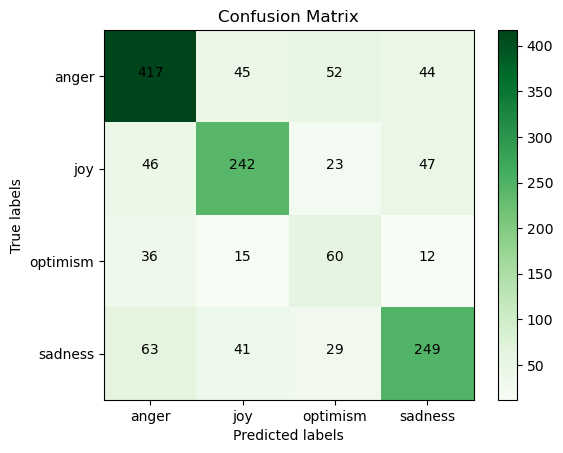

In [47]:
# confusion matrix
conf_matrix = confusion_matrix(test_labels, y_test_pred)

# map emotion labels
emotion_labels = {0: 'anger', 1: 'joy', 2: 'optimism', 3: 'sadness'}

plt.figure()
plt.imshow(conf_matrix, cmap='Greens', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = range(len(conf_matrix))
plt.xticks(tick_marks, [emotion_labels[i] for i in range(len(conf_matrix))])
plt.yticks(tick_marks, [emotion_labels[i] for i in range(len(conf_matrix))])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# add counts in the matrix
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, str(conf_matrix[i][j]), horizontalalignment='center', color='black')

plt.show()


## Experiment 13 TfidfVectorizer with Experiment 6 with Tuning Hyperparameter with Lexicon (EXP9 in report)

In [48]:
nltk.download('vader_lexicon')

analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/blackrose/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [49]:
tf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=None, min_df=1, ngram_range=(1, 1))

tf_vectorizer.fit(train_documents)

X_train = tf_vectorizer.fit_transform(train_documents)
X_val = tf_vectorizer.transform(val_documents)
X_test = tf_vectorizer.transform(test_documents)

In [50]:
print(list(vectorizer.vocabulary_)[:20])

vocabulary = tf_vectorizer.vocabulary_

lex_pos_scores = np.zeros((1, len(vocabulary)))
lex_neg_scores = np.zeros((1, len(vocabulary))) 

# get the Vader lexicon scores
for i, term in enumerate(vocabulary):
    if term in analyser.lexicon and analyser.lexicon[term] > 0:
        lex_pos_scores[0, i] = 1
    elif term in analyser.lexicon and analyser.lexicon[term] < 0:
        lex_neg_scores[0, i] = 1


['worry', 'is', 'down', 'payment', 'on', 'problem', 'you', 'may', 'never', 'have', 'joyce', 'meyer', 'motivation', 'leadership', 'my', 'roommate', 'it', 'okay', 'that', 'we']


In [51]:
lex_pos_train = np.sum(X_train.multiply(lex_pos_scores), axis=1)
lex_pos_test = np.sum(X_test.multiply(lex_pos_scores), axis=1)
lex_pos_val = np.sum(X_val.multiply(lex_pos_scores), axis=1)
lex_neg_val = np.sum(X_val.multiply(lex_neg_scores), axis=1)
lex_neg_train = np.sum(X_train.multiply(lex_neg_scores), axis=1)
lex_neg_test = np.sum(X_test.multiply(lex_neg_scores), axis=1)


In [52]:
# concatenate the lexicon features
X_train = hstack((X_train, lex_pos_train, lex_neg_train))
X_val = hstack((X_val, lex_pos_val, lex_neg_val))
X_test = hstack((X_test, lex_pos_test, lex_neg_test))

In [53]:
classifier = LogisticRegression(C=4, max_iter=1000, random_state=10, class_weight='balanced')
classifier.fit(X_train, train_labels)

# predict on validation and train set
y_val_pred = classifier.predict(X_val)
y_train_pred = classifier.predict(X_train)


acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(train_labels, y_train_pred, average='macro')
print(f'F1 score (macro average) of train = {f1}')

f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) of val = {f1}')

print(classification_report(val_labels, y_val_pred))

Accuracy = 0.6550802139037433
Precision (macro average) = 0.5896750607116461
Recall (macro average) = 0.5943308277208718
F1 score (macro average) of train = 0.9775163068512539
F1 score (macro average) of val = 0.5865692618758831
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       160
           1       0.71      0.57      0.63        97
           2       0.29      0.43      0.35        28
           3       0.61      0.61      0.61        89

    accuracy                           0.66       374
   macro avg       0.59      0.59      0.59       374
weighted avg       0.67      0.66      0.66       374

